In [99]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from collections import deque
%matplotlib notebook

In [107]:
'''INISIASI CLASS'''
class Node:

    def __init__(self, name):
        self.name = name
        self.neighbours = []
        self.f = 0
        self.g = 0
        self.h = 0
        self.x = 0
        self.y = 0
    def AddNeighbour(self, neighbour):
        self.neighbours.append(neighbour)
    def SetParent(self, parent):
        self.parent = parent
    def SetH(self, h):
        self.h = h
    def SetG(self, g):
        self.g = g
    def SetF(self, f):
        self.f = f
    def GetG(self, g):
        return self.g
    def GetH(self, h):
        return self.h
    def GetParent(self):
        return self.parent
    def GetNeighbour(self):
        return self.neighbours
    def FindF(self):
        return self.g + self.h

class Graph:

    def __init__(self):
        self.ListOfNode = []
        self.ListOFNodePosition = []
        self.AdjMatrix = []
        self.nNode = 0
    def InsertNode(self, node):
        self.ListOfNode.append(node)
    def GetNode(self, idx):
        try:
            return self.ListOfNode[idx]
        except:
            return None
    def GetNodeNeighbour(self, idx):
        return self.ListOfNode[idx].GetNeighbour()
    def ReadFromFile(self, filename):
        try:
            f = open("" + filename, "r")
        except:
            print("Salah memasukkan nama file")
            return
        i = 0
        lines = f.readlines()
        # Get n node
        self.nNode = int(lines[0].replace("\n", ""))
        # Get position
        for i in range (self.nNode):
            line = lines[i+1].replace("\n", "").split("|")
            # ["A", "2,3"]
            # versi 1
            node = Node(line[0])
            node.x = line[1].split(",")[0]
            node.y = line[1].split(",")[1]
            self.ListOfNode.append(node)
            # versi 2
            x = line[1].split(",")[0]
            y = line[1].split(",")[1]
            self.ListOFNodePosition.append((float(x), float(y)))
        # Get tetangga
        i = 0
        for i in range (self.nNode):
            line = lines[self.nNode+1+i].replace("\n", "").split(",")
            # Get Node
            node = self.ListOfNode[i]
            j = 0
            for adj in line[1:]:
                if adj == "1":
                    node.AddNeighbour(self.ListOfNode[j])
                j+=1
            self.ListOfNode[i] = node
    def PrintGraph(self):
        for node in self.ListOfNode:
            print(node.name, end =" ")
            for neighbour in node.neighbours:
                print(neighbour.name, end=" ")
            print("")

    def distance(self, node1, node2):
        if node1 == None or node2 == None:
            return 0
        return math.sqrt(pow((float)(node1.x)-(float)(node2.x),2) + pow((float)(node1.y)-(float)(node2.y),2))

    def HaversineDistance(self, node1, node2):
        R = 6378137
        dlat = self.rad((float)(node1.x) - (float)(node2.x))
        dlong = self.rad((float)(node1.y) - (float)(node2.y))
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(self.rad(node1.x))*math.cos(self.rad(node2.x))*math.sin(dlong/2)*math.sin(dlong/2)
        c = math.asin(math.sqrt(a))
        d = R *c
        return d
    
    def rad(self, x):
        return (float)(x)*math.pi/180

    def bobot(self, node_name1, node_name2):
        node1 = self.ListOfNode[self.GetNodeIdx(node_name1)]
        node2 = self.ListOfNode[self.GetNodeIdx(node_name2)]
        if node1.name in node2.neighbours:
            return self.distance(node1, node2)
        return 0
    
    def IsNodeInSet(self, node, list_node):
        for nodes in list_node:
            if node == nodes:
                return True
        return False

    def GetNodeIdx(self, node_name):
        i = 0
        for node in self.ListOfNode:
            if node.name == node_name:
                return i
            i+=1
            
    def GetListOfNode(self):
        return self.ListOfNode

    def getLowestF(self, openSet, fScore):
        lowest = float("inf")
        lowestNode = None
        for node in openSet:
            if fScore[node] < lowest:
                lowest = fScore[node]
                lowestNode = node
        return lowestNode
    
    def reconstructPath(self, cameFrom, goal):
        path = deque()
        node = goal
        path.appendleft(node)
        while node in cameFrom:
            node = cameFrom[node]
            path.appendleft(node)
        return path
    def getNodeFromName(self, node_name):
        for node in self.ListOfNode:
            if node.name == node_name:
                return node

def aStar(graph, start, goal):
    #Inisialisasi open list dan closed list
    start = graph.getNodeFromName(start)
    goal = graph.getNodeFromName(goal)
    
    cameFrom = {}
    openSet = set([start])
    closedSet = set()
    
    gScore = {} #untuk simpan nilai g
    fScore = {} #untuk simpan nilai f
    
    gScore[start] = 0 #set g score start node dengan 0
    fScore[start] = gScore[start]+graph.HaversineDistance(start,goal) #set f score start node 
    
    #iterasi selama openset tidak 0
    while (len(openSet) != 0):
        #set current node dengan node yang punya lowest f
        current = graph.getLowestF(openSet, fScore)
        #jika current node sama dengan yang dicari
        if current == goal:
            return (graph.reconstructPath(cameFrom, goal), fScore[current])
        #remove current node dari openSet
        openSet.remove(current)
        #tambahkan current node ke closedSet
        closedSet.add(current)
        #lakukan pencarian nilai f ke semua tetangga dari current node
        if (len(goal.neighbours)!=0):
            for neighbour in current.neighbours:
                node_neighbour = graph.getNodeFromName(neighbour.name)
                tentative_gScore = gScore[current] + graph.HaversineDistance(current, node_neighbour)
                if node_neighbour in closedSet:
                    continue
                if node_neighbour in gScore:
                    if tentative_gScore > gScore[node_neighbour]:
                        continue
                if node_neighbour not in closedSet or tentative_gScore < gScore[node_neighbour]:
                    cameFrom[node_neighbour] = current
                    gScore[node_neighbour] = tentative_gScore
                    fScore[node_neighbour] = gScore[node_neighbour] + graph.HaversineDistance(node_neighbour,goal)
                    if node_neighbour not in openSet:
                        openSet.add(node_neighbour)
        else :
            print("Tidak bisa akses kesana")
    path = deque()
    return (path, 0)

# Tuple node untuk visualisasi graf
def TupleOfEdge(listofnode, matrix, listofpos):
    listoftuple = []
    for i in range(len(listofnode)):
        for j in range(i, len(listofnode)):
            if matrix[i][j] == '1':
                edge = (listofnode[i], listofnode[j], {'weight': round(HaversineDistance(i, j, listofpos), 2), 'node_size': 500})
                listoftuple.append(edge)
    return listoftuple

def rad(x):
    return x*math.pi/180

# Menghitung jarak dengan haversine formula
def HaversineDistance(idx_node1, idx_node2, listofpos):
    R = 6378137
    node1 = listofpos[idx_node1]
    node2 = listofpos[idx_node2]
    dlat = rad(node1[0] - node2[0])
    dlong = rad(node1[1] - node2[1])
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(rad(node1[0]))*math.cos(rad(node2[0]))*math.sin(dlong/2)*math.sin(dlong/2)
    c = math.asin(math.sqrt(a))
    d = R *c
    return d

# Untuk testing
def EuclidianDistance(idx_node1, idx_node2, listofpos):
    node1 = listofpos[idx_node1]
    node2 = listofpos[idx_node2]
    x = node1[0] - node2[0]
    y = node1[1] - node2[1]
    return math.sqrt(x**2 + y**2)

# Tidak terpakai
def LongLatToXY(long, lat):
    return (6378137*math.cos(lat)*math.cos(long), 6378137*math.cos(lat)*math.sin(long))
def LongLatToX(long, lat):
    return (6378137*math.cos(lat)*math.cos(long))
def LongLatToY(long, lat):
    return (6378137*math.cos(lat)*math.sin(long))
def PrintHeuristic(nodes, nodespos, goal_node):
    idx = 0
    for i in range(len(nodes)):
        if nodes[i] == goal_node:
            idx = i
            break
    print("Jarak dari " + goal_node + " dalam meter : ")
    i = 0
    for node in nodespos:
        print(nodes[i], end=" : ")
        print(HaversineDistance(idx, i, nodespos))
        i+=1

In [108]:
'''INPUT NAMA FILE'''
file = input("Masukkan nama file: ")

Masukkan nama file: test.txt


In [109]:
''' FOR VISUALIZATION '''
astar_graph = Graph()
filename = file
try:
    f = open(filename, "r")
    astar_graph.ReadFromFile(filename)
    i = 0
    lines = f.readlines()
    ListOfNode = []
    ListOfNodePosition = []
    # Get n node
    nNode = int(lines[0].replace("\n", ""))
    AdjMatrix = [[] for i in range (nNode)]
    # Get position
    for i in range (nNode):
        line = lines[i+1].replace("\n", "").split("|")
        x = line[1].split(",")[0]
        y = line[1].split(",")[1]
        ListOfNodePosition.append((float(x), float(y)))
    # Get tetangga
    for i in range (nNode):
        line = lines[nNode+1+i].replace("\n", "").split(",")
        adj = line[1::]
        # Get Node
        ListOfNode.append(line[0])
        AdjMatrix[i] = adj
except:
    print("Salah memasukkan nama file")

<IPython.core.display.Javascript object>


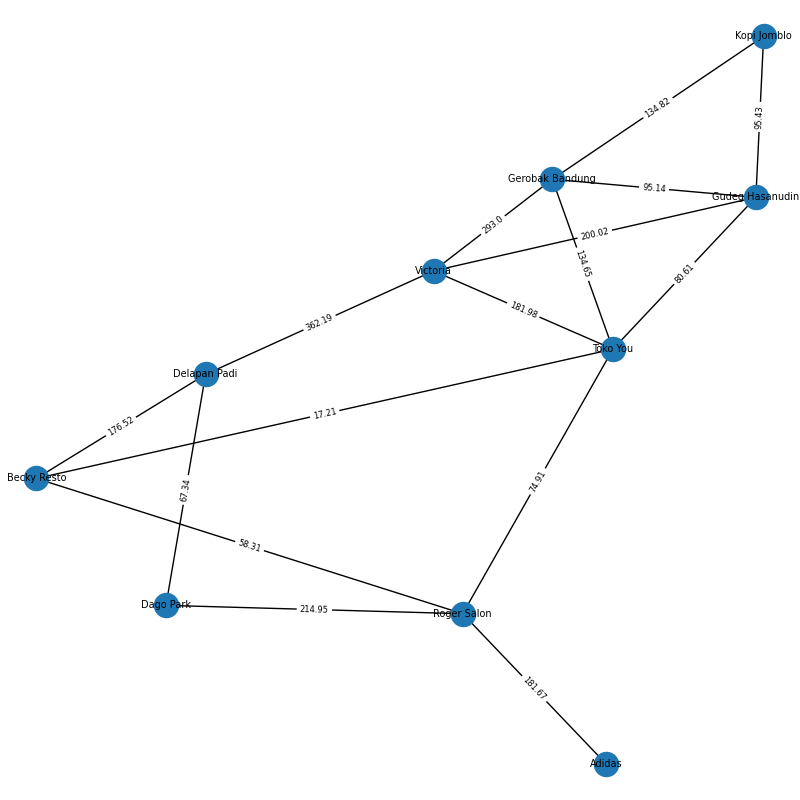

In [110]:
''' GRAPH VISUALIZATION '''
%matplotlib notebook
plt.figure(figsize=(8, 8))
G = nx.Graph()

# Menambahkan node
idx = 0
for node in ListOfNode:
    lat = ListOfNodePosition[idx][0]
    long = ListOfNodePosition[idx][1]
    G.add_node(node, pos=(lat*100, long*100))
    idx+=1

# Menambahkan sisi pada graf dengan bobot masing-masing sisi
G.add_edges_from(TupleOfEdge(ListOfNode, AdjMatrix, ListOfNodePosition))

# label untuk bobot pada graf
labels = nx.get_edge_attributes(G, "weight")

# Layout untuk menggambarkan graf dengan representasi pos
position=nx.get_node_attributes(G,'pos')
layout = nx.spring_layout(G, pos=position)
nx.draw(G, layout, with_labels=True, font_size = 7)

# Menambahkan label bobot
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels, font_size = 6)

plt.axis("off")
plt.title("Tampilan Peta")
plt.show()

Masukkan node asal: Adidas
Masukkan node tujuan: Kopi Jomblo

Jalur : 
Adidas
Roger Salon
Toko You
Gudeg Hasanudin
Kopi Jomblo
Total Jarak : 432.62174460456254 meter

Jarak dari Kopi Jomblo dalam meter : 
Adidas : 291.52155755833166
Roger Salon : 249.91497930959778
Dago Park : 338.5581323666646
Delapan Padi : 273.57028553894474
Becky Resto : 192.52973990540264
Toko You : 175.41215741361364
Victoria : 242.61388868637022
Gerobak Bandung : 134.81601481157824
Gudeg Hasanudin : 95.4305602286995
Kopi Jomblo : 0.0


<IPython.core.display.Javascript object>


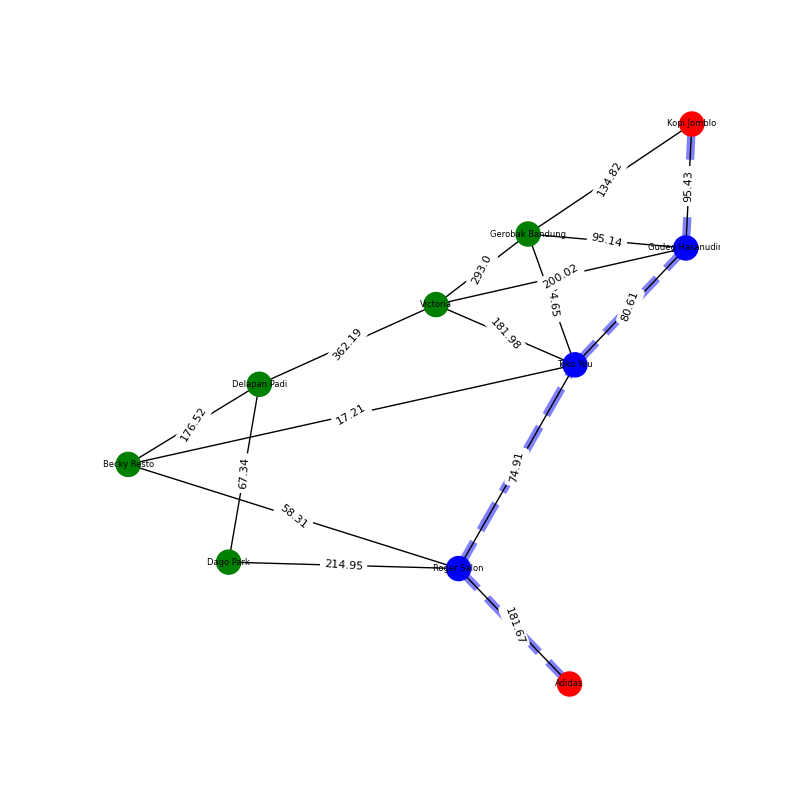

In [111]:
''' INPUT NODE ASAL DAN TUJUAN '''
start_node = input("Masukkan node asal: ")
goal_node = input("Masukkan node tujuan: ")
print()
# Perhitungan path
(path,weight) = aStar(astar_graph, start_node, goal_node)
if (path):
    print("Jalur : ")
    for i in range(len(path)):
        print(path[i].name)
    print("Total Jarak : ", end="")
    print(weight, end=" ")
    print("meter")
else:
    print("Tidak ada jalur")
    
    
print()
''' ROUTE VISUALIZATION '''
%matplotlib notebook

# Tampilkan h(n)
PrintHeuristic(ListOfNode, ListOfNodePosition, goal_node)

routes = []
for route in path:
    routes.append(route.name)
    
# make a tuple untuk visualisasi 
edges = []
for i in range (len(routes)-1):
    edges.append((routes[i], routes[i+1]))

plt.figure(figsize=(8, 8))

# sisi graf
nx.draw_networkx_edges(
    G, layout, edgelist=edges, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# label sisi
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels, font_size = 8)

# warna node
color_map = []
for node in G:
    if node == start_node or node == goal_node:
        color_map.append('red')
    else:
        if node in routes:
            color_map.append('blue')
        else: 
            color_map.append('green')  
# insert layout
nx.draw(G, layout, node_color=color_map, with_labels=True, font_size = 6)
#plt.xlim(-1.5, 1.5)
#plt.ylim(-1.5, 1.5)
plt.axis("off")
plt.show()

In [112]:
"""DRAW MAP"""
from ipyleaflet import (
    Map, basemaps, basemap_to_tiles,
    Circle, Marker, Rectangle, LayerGroup, AntPath
)
arraypos = []
for i in range(len(astar_graph.ListOfNode)):
    coord = [float(ListOfNodePosition[i][0]), float(ListOfNodePosition[i][0])]
    arraypos.append(coord)

# map center
center = ListOfNodePosition[0]
m = Map(center=center, zoom=15)

# map marker min 2
# TODO Label?, icon
marker = Marker(location=center, draggable=False)
marke2 = Marker(location=ListOfNodePosition[1], draggable=False)

# Create layer group
layer_group = LayerGroup(layers=(marker, marke2))

# Create some layers
for position in ListOfNodePosition:
    marker = Marker(location=position, draggable=False)
    layer_group.add_layer(marker)
m.add_layer(layer_group)
m

Map(center=[-6.891491148092906, 107.61322257455488], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [113]:
"""DRAW ROUTE"""
# Get position based on path
coord = []
if(path):
    for i in range(len(path)):
        # catat posisi node
        point = [float(path[i].x), float(path[i].y)]
        coord.append(point)
        

# Draw Path
mPath = Map(center=(path[0].x, path[0].y), zoom=15)
markerStart = Marker(location=(path[0].x, path[0].y), draggable=False, rise_on_hover=True)
markerGoal = Marker(location=(path[len(path)-1].x, path[len(path)-1].y), draggable=False, rise_on_hover=True)

layer_group = LayerGroup(layers=(markerStart, markerGoal))
mPath.add_layer(layer_group)

#TODO: Hover pop up label
ant_path = AntPath(
    locations=coord,
    dash_array=[1, 10],
    delay=1000,
    color='#7590ba',
    pulse_color='#3f6fba'
)
layer_group.add_layer(ant_path)

mPath

Map(center=['-6.891491148092906', '107.61322257455488'], controls=(ZoomControl(options=['position', 'zoom_in_t…